# 0. Imports and functions definitions

In [1]:
import numpy as np
import random, uproot, math
import matplotlib.pyplot as plt
from scipy import signal

def solid_angle(x,y,z):#VUV case
    return np.arctan(x*y/(z*np.sqrt(x**2 + y**2 + z**2)))

def solid_angle_cos(x,y,z):
    #Solid angle weighted by cos(theta) (difuser): ONLY FOR VISIBLE LIGHT
    return -((z*np.arctan (y/np.sqrt(x**2 + z**2)))/(2 *np.sqrt(x**2 + z**2)))

def double_integral_evaluation(function,x0,x1,y0,y1,z):
    return (function(x1, y1, z) - function(x1, y0, z) - function(x0, y1, z) + function(x0, y0, z))

def convolve_with_gaussian(arr, sigma, amplitude):
    x = np.arange(-3*sigma, 3*sigma+1) # create a window of 3*sigma width
    kernel = amplitude * np.exp(-0.5 * (x / sigma) ** 2) # compute the Gaussian kernel
    kernel /= np.sum(kernel) # normalize the kernel
    convolved = signal.convolve(arr, kernel, mode='same') # convolve the array with the kernel
    return convolved


# 1. Analytic MC integral-method - SBND template

In [2]:
#=============================#
##### SBND CONFIGURATION #####
# XARAPUCA - SolidAngle #
side1 = 37.5*2;       #mm
side2 = 49*2;         #mm
x0 = 0;               #mm
x1 = side1-(37.5-27); #mm
y0 = -side2/2;        #mm
y1 = side2/2;         #mm
z  = 55;              #mm
alpha_source_rad = 11;#mm
#=============================#

angles = []; y_cords = []; z_cords = [];
for i in range(100000):
    r   = alpha_source_rad * math.sqrt(random.random()) # random position in the radius
    phi = 2 * math.pi * random.random()               # random angle
    y_corr = r * math.cos(phi) # calculate y coordinate
    z_corr = r * math.sin(phi) # calculate z coordinate
    y_cords.append(y_corr)

    angle = double_integral_evaluation(solid_angle,x0,x1,y0-y_corr,y1-y_corr,z-z_corr)
    angles.append(angle)

XA_angles=np.array(angles)

In [3]:
#=============================#
##### SBND CONFIGURATION #####
# SiPM - SolidAngle #
center = 53 - 46.3    #mm
side = 6;             #mm
x0 = center - side/2; #mm
x1 = center + side/2; #mm
y0 = -side/2;         #mm
y1 = side2/2;         #mm
z  = 26 + 27;         #mm
alpha_source_rad = 11;#mm
#=============================#

angles = []; y_cords = []; x_cords = [];
for i in range(1000000):
    r   = alpha_source_rad * math.sqrt(random.random()) # random position in the radius
    phi = 2 * math.pi * random.random()                 # random angle
    x_corr = r * math.cos(phi) # calculate y coordinate
    y_corr = r * math.sin(phi) # calculate y coordinate
    x_cords.append(x_corr)
    y_cords.append(y_corr)

    angle = double_integral_evaluation(solid_angle,x0-x_corr,x1-x_corr,y0-y_corr,y1-y_corr,z)
    angles.append(angle)

SiPM_angles=np.array(angles)

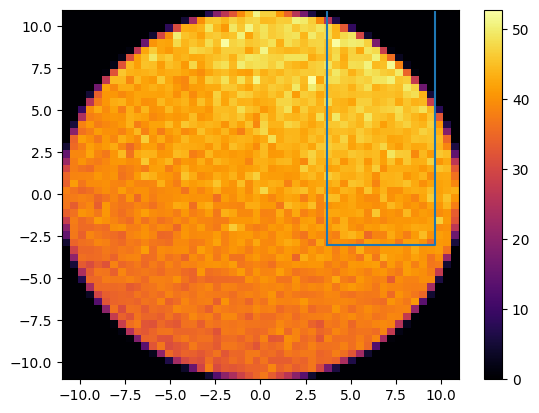

In [10]:
plt.hist2d(x_cords,y_cords, bins=50, range=[[-11, 11], [-11, 11]], weights=SiPM_angles,cmap='inferno');
plt.plot([x0,x0,x1,x1,x0],[y0,y1,y1,y0,y0])
plt.colorbar()
plt.show()

Simulation made with SBND geometry (stored in "pc/choozdsk01/palomare/GEANT4/192k_ev_100k_evs.root") 

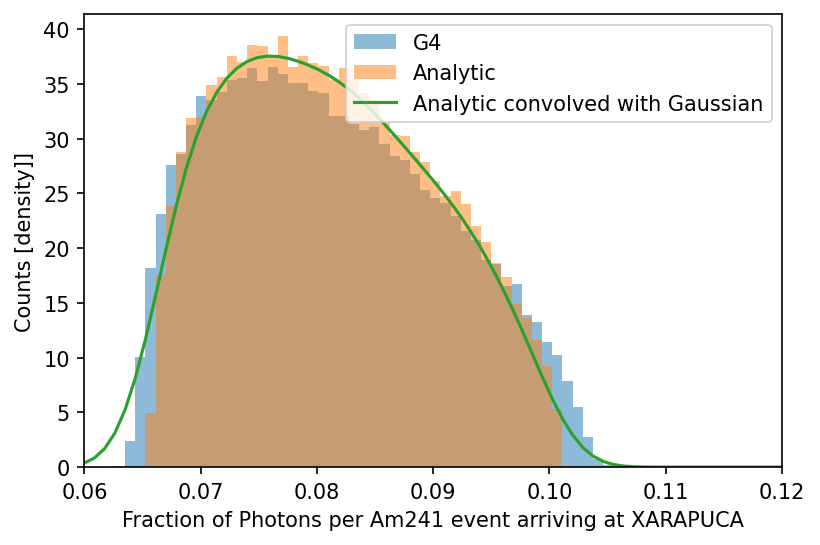

In [5]:
my_file = uproot.open("pc/choozdsk01/palomare/GEANT4/192k_ev_100k_evs.root")
sensor  = my_file["Hits"]["fsensor"] .array().to_numpy()
nhits   = my_file["Hits"]["acumHits"].array().to_numpy()
n_ph_ev = 192000;
XA_G4   = nhits[sensor==0]/n_ph_ev

plt.figure(dpi=150)
plt.hist(XA_G4,80,[0.06,0.13],density=True,alpha=.5,label="G4");
a = plt.hist(XA_angles/(4*np.pi)*0.96,80,[0.06,0.13],density=True,alpha=.5,label="Analytic");

sigma = 3.0
amplitude = 1/np.sqrt(2*np.pi*sigma**2)
guess=convolve_with_gaussian(a[0], sigma, amplitude)
plt.plot(a[1][:-1],guess,label="Analytic convolved with Gaussian")
plt.xlim([0.06,0.12])

plt.xlabel("Fraction of Photons per Am241 event arriving at XARAPUCA") 
plt.ylabel("Counts [density]]") 

plt.legend()
plt.show()

Text(0, 0.5, 'Number of events')

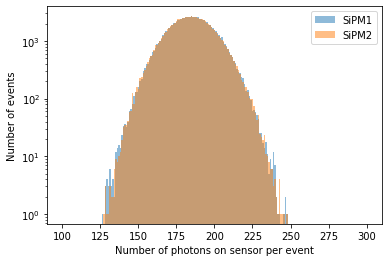

In [6]:
my_file = uproot.open("192k_ev_100k_evs.root")
sensor = my_file["Hits"]["fsensor"] .array().to_numpy()
nhits  = my_file["Hits"]["acumHits"].array().to_numpy()

plt.hist(nhits[sensor==1], 201, [100,300], alpha=.5, label="SiPM1");
plt.hist(nhits[sensor==2], 201, [100,300], alpha=.5, label="SiPM2");
plt.semilogy()
plt.legend()
plt.xlabel("Number of photons on sensor per event")
plt.ylabel("Number of events")
plt.show()

In [7]:
Eff = 14.7/100
nhits[sensor==2].mean()*Eff*2

54.29511055110551

In [ ]:
plt.hist(SiPM_angles/(4*np.pi)    ,115,[0.0007,0.0013],alpha=.5,density=True,histtype="step",label="Analytic");
plt.hist(nhits[sensor==1]/(1.92e5),115,[0.0007,0.0013],alpha=.5,density=True,histtype="step",label="G4");
# plt.semilogy()
plt.show()

Text(0.5, 1.0, 'SiPM 4')

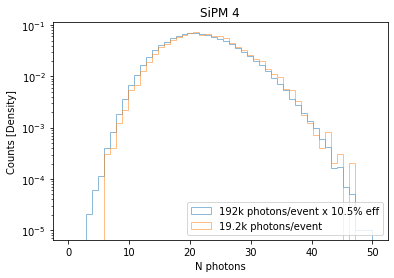

In [9]:
efficiency = 0.145*0.7
sen = 4

z = 0; aux = np.zeros(nhits[sensor==sen].shape[0])
for nphot in nhits[sensor==sen]:
    dice=np.random.uniform(0,1,int(nphot))
    measured=np.sum(dice<efficiency)
    aux[z]=measured
    z=z+1;


plt.hist(aux,51,[0,50],alpha=.5,histtype="step",density=True,label="G4 with efficiency");
plt.semilogy()

my_file = uproot.open("10k_test_only_accum.root")
sensor2 = my_file["Hits"]["fsensor"]  .array().to_numpy()
nhits2  = my_file["Hits"]["acumHits"].array().to_numpy()
plt.hist(nhits2[sensor2==sen],51,[0,50],alpha=.5,histtype="step",density=True,label="G4 with efficiency");
plt.legend(["192k photons/event x 10.5% eff","19.2k photons/event"],loc="lower right")

plt.ylabel("Counts [Density]")
plt.xlabel("N photons")
plt.title("SiPM "+str(sen))
plt.show()

## Analytic method - MEGACELL_v1

In [10]:
#=============================#
##### MEGACELL_v1 CONFIGURATION #####
# SiPM - SolidAngle #
side1 = 6;             #mm
side2 = 6;             #mm
x0    = 0;             #mm
x1    = side1;         #mm
y0    =  - side2/2;    #mm
y1    =  + side2/2;    #mm
z     = 70.7;          #mm
alpha_source_rad = 11; #mm
#=============================#

angles =[]; angles2=[]; y_cords=[]; z_cords=[];
for i in range(1000000):
    r = alpha_source_rad * math.sqrt(random.random())# random angle
    phi = 2 * math.pi * random.random() # random angle
    y_corr = r * math.cos(phi) # calculate y coordinate
    z_corr = r * math.sin(phi) # calculate z coordinate

    y_cords.append(y_corr)
    angle=double_integral_evaluation(solid_angle,x0,x1,y0+y_corr,y1+y_corr,z-z_corr)
    angle2=double_integral_evaluation(solid_angle,x0,x1,y0+y_corr,y1+y_corr,z+z_corr)
    
    angles.append(angle)
    angles2.append(angle2)

XA_angles=np.array(angles)
XA_angles2=np.array(angles2)

In [11]:
# efficiency=.14

geant4_rough =(XA_angles *10000).astype(int)
geant4_rough2=(XA_angles2*10000).astype(int)
# re_escaled=[np.random.poisson(N_ph*efficiency) for N_ph in geant4_rough]

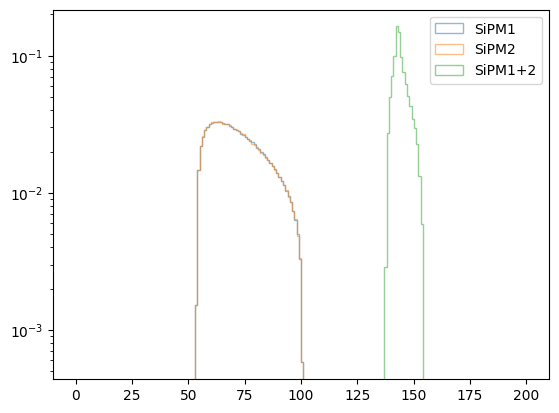

In [12]:
plt.hist(geant4_rough,150,[0,150],alpha=.5,density=True,histtype="step"              ,label="SiPM1");
plt.hist(geant4_rough2,150,[0,150],alpha=.5,density=True,histtype="step"             ,label="SiPM2");
plt.hist(geant4_rough2+geant4_rough,200,[0,200],alpha=.5,density=True,histtype="step",label="SiPM1+2");
plt.legend()
plt.semilogy()
plt.show()
# plt.figure()
# plt.hist(re_escaled,50,[0,50],alpha=.5,density=True,histtype="step",label="Analytic");

# plt.semilogy()

## Fit

In [20]:
charges_dec=np.load("alpha_source_spectrum_OV_9.npy")
print(np.mean(charges_dec))

279.09924126064556


(100.0, 500.0)

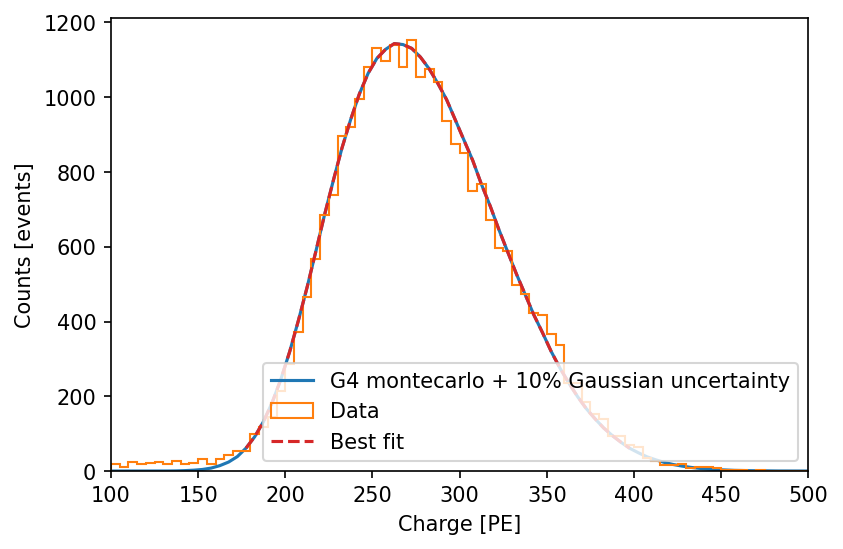

In [31]:
elec_smear=0.10
efficiency=0.0178
sen=0


if True:
# if not ( ( "aux_binom" in locals() ) or ( "aux_binom" in globals() ) ):#run only once
    aux_binom=np.zeros(nhits[sensor==sen].shape[0])
    aux_poiss=np.zeros(nhits[sensor==sen].shape[0])

    z=0
    for nphot in nhits[sensor==sen]:
        # ## binomial distribution for each photon. 1=detected, 0=not detected
        # dice=np.random.uniform(0,1,int(nphot)) 
        # aux_binom[z]=np.sum(dice<efficiency)
        
        ## poisson distribution, faster but less accurate for low number of photons (the tails are not well reproduced)
        lambda_ = efficiency * nphot
        aux_poiss[z]   =np.random.poisson(lambda_)
        z+=1;

#MC
MC=aux_poiss
a=np.histogram(MC,200,[0,1000])

np.save("unfolding/MC.npy",MC)
# a=plt.hist(MC,200,[0,1000],histtype="step",weights=np.ones(aux.shape[0])*charges_dec.shape[0]/aux.shape[0],label="G4 montecarlo");

RANGE=100
aux_MC=np.zeros((RANGE,a[0].shape[0]))
plt.figure(dpi=150)

for i in range(RANGE):
    a=np.histogram(aux_poiss*np.random.normal(1, elec_smear, int(MC.shape[0])),int(200),[0,1000],weights=np.ones(aux.shape[0])*charges_dec.shape[0]/aux.shape[0]);
    aux_MC[i,:]=a[0]

# a=plt.hist(np.mean(aux_MC,axis=0),200,[0,1000],histtype="step",weights=np.ones(aux.shape[0])*charges_dec.shape[0]/aux.shape[0],label="G4 montecarlo + 10% Gaussian uncertainty");
plt.plot((a[1][1:]+a[1][:-1])/2,np.mean(aux_MC,axis=0),label="G4 montecarlo + 10% Gaussian uncertainty");
#Data
DATA=charges_dec
np.save("unfolding/DATA.npy",DATA)

np.save("unfolding/MC_reco.npy",[np.mean(aux_MC,axis=0) , ((a[1][1:]+a[1][:-1])/2)])

b=np.histogram(DATA,200,[0,1000])

plt.hist(DATA,200,[0,1000],histtype="step",label="Data");

plt.plot(((a[1][1:]+a[1][:-1])/2)[35:80],np.mean(aux_MC,axis=0)[35:80],"--",color="tab:red",label="Best fit");
plt.legend(loc="lower right")
plt.xlabel("Charge [PE]")
plt.ylabel("Counts [events]")

# plt.semilogy()
plt.xlim([100,5e2])
# plt.ylim([1,5e3])

In [11]:
#chi2 tests

def chisq_scan(npixels=100):
    
    def chisq(a,b,dof=1):
        return np.sum((a-b)**2/b)/dof
    
    aux_chisq=[]
    aux_eff=[]

    RANGE=100
    elec_res=0.10
    effi_range=np.linspace(0.0172,0.0186 ,npixels)

    for efficiency in effi_range:

        aux_poiss=np.zeros(nhits[sensor==sen].shape[0])

        z=0
        for nphot in nhits[sensor==sen]:
            ## poisson distribution, faster but less accurate for low number of photons (the tails are not well reproduced)
            lambda_ = efficiency * nphot
            aux_poiss[z]   =np.random.poisson(lambda_)
            z+=1;


        aux_MC=np.zeros((RANGE,b[0].shape[0]))
        for i in range(RANGE):
            a=np.histogram(aux_poiss*np.random.normal(1, elec_res, int(MC.shape[0])),int(200),[0,1000],weights=np.ones(aux.shape[0])*charges_dec.shape[0]/aux.shape[0]);
            aux_MC[i,:]=a[0]
            
        x=np.mean(aux_MC,axis=0) [35:80]
        y=b[0]                   [35:80]
        aux_chisq.append(chisq(y,x,dof=len(x)-1))
        aux_eff.append(efficiency)
    return np.array(aux_chisq),np.array(aux_eff)



In [12]:
aux_chisq,aux_eff=chisq_scan()

In [15]:
np.mean(DATA)

279.09924126064556

0.01787878787878788
1.8145767630549825
0.00022626262626262647 0.0002686868686868661


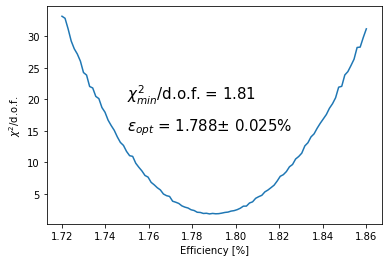

In [13]:
plt.plot(aux_eff*100,aux_chisq)
print(aux_eff[np.argmin(aux_chisq)])
print(aux_chisq[np.argmin(aux_chisq)])
plt.ylabel(r"$\chi^2$/d.o.f.")
plt.xlabel("Efficiency [%]")

threshold=4
minus=aux_eff[np.argmin(aux_chisq)]-aux_eff[np.min(aux_chisq)+threshold>aux_chisq][0]
plus =aux_eff[np.min(aux_chisq)+threshold>aux_chisq][-1] - aux_eff[np.argmin(aux_chisq)]

plt.text(1.75,20, r'$\chi^2_{min}$/d.o.f. = '+str(round(aux_chisq[np.argmin(aux_chisq)],2)), fontsize=15)
plt.text(1.75,15, r'$\epsilon_{opt}$ = '+str(round(aux_eff[np.argmin(aux_chisq)]*100,3))+"$\pm$ "+str(round((minus+plus)/2*100,3))+"%", fontsize=15)

print(minus,plus)

In [276]:
print(aux_eff[np.argmin(aux_chisq)])
print(aux_elec[np.argmin(aux_chisq)])ç

0.01785
0.105


In [28]:
charges_dec=np.load("Daphne_9OV_alpha_source_spectrum.npy")
np.mean(charges_dec)

279.68032646080735